In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def stochastic_shm_sde(n_timesteps, dt, b, w, sigma_q=1.0, m_0=np.zeros(2), P_0=np.eye(2), sub_step=10):
    F = np.array([[0, 1], [- w * w, -b]])
    L = np.array([0, 1])
    
    t_T = np.zeros(n_timesteps + 1)
    x_T = np.zeros((n_timesteps + 1, 2))
    
    x_T[0] = np.random.multivariate_normal(m_0, P_0)
    d_dt = dt / sub_step
    
    for t in range(1, n_timesteps + 1):
        x_int = x_T[t - 1]
        
        for _ in range(sub_step):
            eps_t = sigma_q * np.random.randn() * np.sqrt(d_dt)
            dx_t = np.matmul(F, x_int) * d_dt + L * eps_t
            x_int = x_int + dx_t
            
        x_T[t] = x_int
        t_T[t] = t_T[t - 1] + dt
    
    return x_T, t_T

In [25]:
def observation_model(x_T, sigma_r=1.0):
    H = np.array([1, 0]).reshape((1, 2))
        
    y_T = np.zeros(len(x_T) - 1)
    for t in range(len(x_T) - 1):
        y_T[t] = np.matmul(H, x_T[t + 1]) + np.random.randn() * sigma_r
    
    return y_T

In [26]:
def sde_kalman_filter(y_T, dt, b, w, sigma_q, sigma_r, m_0=np.zeros(2), P_0=np.eye(2), sub_step=10):
    F = np.array([[0, 1], [- w * w, -b]])
    Q = np.array([[0, 0], [0, sigma_q ** 2]])
    H = np.array([1, 0]).reshape(1, 2)
    
    
    m_prev = m_0.reshape((2, 1))
    P_prev = P_0
    
    m_filter = np.zeros((len(y_T), 2, 1))
    P_filter = np.zeros((len(y_T), 2, 2))
    
    for t in range(len(y_T)):
        # Prediction Step: Numerical Integration
        m_int = m_prev
        P_int = P_prev
        d_dt = dt / sub_step
        for _ in range(sub_step):
            increment_m = np.matmul(F, m_int)
            increment_P = np.matmul(F, P_int) + np.matmul(P_int, F.T) + Q
                
            m_int = m_int + increment_m * d_dt
            P_int = P_int + increment_P * d_dt

        # Update Step
        v = y_T[t] - np.matmul(H, m_int)
        S = np.matmul(H, np.matmul(P_int, H.T)) + sigma_r ** 2
        K = np.matmul(P_int, H.T) / S
        
        m_prev = m_int + np.matmul(K, v)
        P_prev = P_int - np.matmul(K, np.matmul(S, K.T))
        
        m_filter[t] = m_prev
        P_filter[t] = P_prev
    m_filter = m_filter.reshape((len(y_T), 2))
    return m_filter, P_filter

            
        
    

In [27]:
n_timesteps = 1000
dt = 0.01
b = 2.0
w = 4.0
sigma_q = 0.5
sigma_r = 1.0
sub_step = 10

In [28]:
x_T, t_T = stochastic_shm_sde(n_timesteps, dt, b, w, sigma_q, sub_step=sub_step)
y_T = observation_model(x_T, sigma_r)

In [29]:
m_filter_euler, P_filter_euler = sde_kalman_filter(y_T, dt, b, w, sigma_q, sigma_r, sub_step=sub_step)

rms_baseline = np.mean((x_T[1:, 0] - y_T) ** 2)
rms_euler = np.mean((x_T[1:, 0] - m_filter_euler[:, 0]) ** 2)

print('Baseline RMSE : {}'.format(rms_baseline))
print('Kalman RMSE : {}'.format(rms_euler))


Baseline RMSE : 1.0078074683339378
Kalman RMSE : 0.016864719332589553


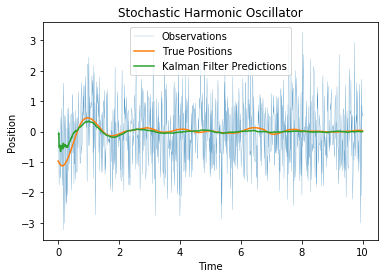

In [30]:
plt.plot(t_T[1:], y_T, linewidth=0.2, label='Observations')
plt.plot(t_T, x_T[:, 0], label='True Positions')
plt.plot(t_T[1:], m_filter_euler[:, 0], label='Kalman Filter Predictions')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Stochastic Harmonic Oscillator')
plt.legend()

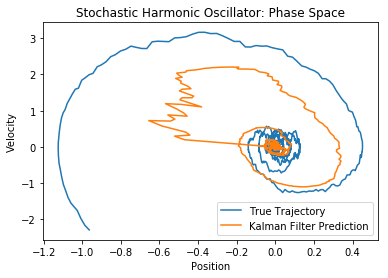

In [31]:
plt.plot(x_T[:, 0], x_T[:, 1], label='True Trajectory')
plt.plot(m_filter_euler[:, 0], m_filter_euler[:, 1], label='Kalman Filter Prediction')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Stochastic Harmonic Oscillator: Phase Space')
plt.legend()

In [22]:
import tqdm
n_rep = 10

rms_b = 0.0
rms_k = 0.0

for _ in tqdm.tqdm(range(n_rep)):
    x_T, t_T = stochastic_shm_sde(n_timesteps, dt, b, w, sigma_q, sub_step=sub_step)
    y_T = observation_model(x_T, sigma_r)
    m_filter_euler, P_filter_euler = sde_kalman_filter(y_T, dt, b, w, sigma_q, sigma_r, sub_step=sub_step)
    rms_b += np.mean((x_T[1:, 0] - y_T) ** 2)
    rms_k += np.mean((x_T[1:, 0] - m_filter_euler[:, 0]) ** 2)

print(rms_b / n_rep, rms_k / n_rep)


100%|██████████| 10/10 [00:01<00:00,  9.69it/s]


1.014714926295441 0.007429317438228449
